# Agrupamentos / *Clustering*
**Plantão 2:** [Jadson Oliveira](https://www.linkedin.com/in/jadsonjjmo/)  
Quinta-feira (17/02/2022)

## O que é?
É uma técnica dentro da Ciência de Dados que envolve o processo de agrupar objetos em diversos grupos. Em teoria, normalmente os objetos pertencentes a um mesmo grupo devem possuir características similares.


É uma técnica de **aprendizado não-supervisionado**.

### Alguns exemplos:
- Dado um conjunto de imagens diversas, gostariamos de criar grupos de imagens com características similares de cores;
- Dado um conjunto de séries temporais que representam o clima de todas as cidades do Brasil ao longo do ano, criar grupos de cidades que apresentam um clima similar;
- Dado um conjunto de documentos de um repositório, criar grupos de documentos que representam o mesmo assunto;
- Dado um conjunto de clientes de uma loja, distinguir grupos de clientes baseado em suas características de compra, com o objetivo de pensar em estratégias de negócios personalizadas aos grupos encontrados.


## Etapas comuns para o processo de aprendizagem não supervisionada utilizando agrupamento de dados

1. Seleção de atributos
    - devem representar a maior quantidade de informação do objeto, levando em consideração o problema a ser resolvido.
    - devem ter redundância mínima entre os atributos
2. Definição de uma medida de proximidade
    - A medida deve informar o quão **similar** ou **dissimilar** são dois objetos;
    - Todos os atributos devem contribuir de maneira igual para a medida de similaridade escolhida,  
    normalmente requer normalização dos dados
3. Definição de um critério para clusterização
    - Uma função custo ou algum tipo de regra que defina um cluster
4. Escolha de um algoritmo de agrupamento
    - Tipo particional
    - Tipo hierárquico
5. Verificação dos resultados
6. Avaliação e interpretação dos resultados

![Algoritmos de agrupamento na biblioteca scikit-learn](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)

Imagem extraída do site oficial da biblioteca open-source Scikit-Learn: https://scikit-learn.org/stable/modules/clustering.html

## Métricas comumente utilizadas para avaliação de agrupamentos

<table class="tg">
<thead>
  <tr>
    <th>Métrica</th>
    <th>Intervalo</th>
    <th>Observação</th>
    <th>Tipo de Índice</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Within Cluster Sum of Squares</td>
    <td>[0, inf]</td>
    <td>Menor melhor</td>
    <td>Indice Relativo</td>
  </tr>
  <tr>
    <td>Adjusted Rand Score</td>
    <td>[0,   1]</td>
    <td>Maior melhor</td>
    <td>Indice Externo</td>
  </tr>
  <tr>
    <td>Adjusted Mutual Information Score</td>
    <td>[0,   1]</td>
    <td>Maior melhor</td>
    <td>Indice Externo</td>
  </tr>
  <tr>
    <td>Silhuete Score</td>
    <td>[-1,  1]</td>
    <td> Maior melhor</td>
    <td>Indice Interno</td>
  </tr>
</tbody>
</table>

Mais métricas podem ser encontradas em: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

# Caso de estudo para o plantão

## Problema:
### Dado um conjunto de imagens de **touros** e **ursos** (referência ao mercado financeiro 😀), como agrupar essas imagens de forma automática, separando as imagens de **urso** para uma pasta específica e as imagens de **touro** para outra pasta específica?

![Imagem de um touro frente a um urso](https://static-wp-eqi15-prd.euqueroinvestir.com/wp-content/uploads/2020/04/bullbear-559x336.jpg)

Imagem extraída do site `euqueroinvestir.com`

---



### Importando as bibliotecas necessárias

In [31]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import shutil

#### Criando funções para auxiliar a extração de características das imagens (features)

In [36]:
directory_path = 'dados_cluster'



# Função para extrair features das imagens, utilizando o modelo pré-treinado InceptionV3
# com pesos baseados no conjunto "imagenet" (Transfer-learning)
def extract_features(directory):

    # Instancia o modelo InceptionV3 baseado no conjunto imagenet
    model = InceptionV3(weights='imagenet', include_top=False)

    features_set = [];
    img_name_set = [];

    # Faz um loop passando por todas as imagens do diretório
    for image_name in tqdm(directory):

        # Obtém o path das imagens
        file_path = f'{directory_path}/{image_name}'

        # Carrega a imagem em memória
        img_loaded = image.load_img(file_path, target_size=(225,225))

        # Tranforma a imagem em um array de valores correspondentes aos
        # seus valores de RGB.
        x = img_to_array(img_loaded)

        # Expande o formato de um array
        x = np.expand_dims(x,axis=0)

        # Realiza um pre-processamento dos valores de RGB extraídos da imagem
        # gerando uma saída onde os valores se encontram no intervalo -1 a 1.
        x = preprocess_input(x)

        # Extrai um conjunto de features utilizando um modelo pré-treinado
        features = model.predict(x)

        # Faz um achatamento na matriz de features retornando um array com
        # uma dimensão
        features = features.flatten()

        # Adiciona as features extraídas da imagem atual na lista contendo todas
        # as features de todas as imagens.
        features_set.append(features)
        img_name_set.append(image_name)

    return features_set, img_name_set

In [37]:
images_path_list = os.listdir(directory_path)

In [38]:
img_features_set, img_name_set = extract_features(images_path_list)

100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


In [39]:
images_cluster = pd.DataFrame(img_name_set, columns=['image'])

In [40]:
print(f'Quantidade de imagens utilizadas: {images_cluster.shape[0]}')
images_cluster.sample(5)

Quantidade de imagens utilizadas: 100


,image
33,touro (40).jfif
62,touro (3).jfif
36,urso (14).jfif
75,touro (1).jfif
57,touro (37).jfif


In [41]:
print(f'Quantidade de features extraídas ela rede: {len(img_features_set[0])}')

Quantidade de features extraídas ela rede: 51200


In [42]:
# Criando um modelo utilizando a técnica de agrupamento K-means

# Definindo o valor de k
k = 2

# Instanciando o modelo
clusters = KMeans(k, random_state = 40)

# Treinando o modelo
clusters.fit(img_features_set)

KMeans(n_clusters=2, random_state=40)

In [43]:
# Criando coluna correspondente aos clusters encontrados
images_cluster["clusterid"] = clusters.labels_

In [44]:
# 0 equivale a urso e 1 equivale a touro
images_cluster.sample(10)

,image,clusterid
82,urso (8).jfif,0
24,touro (12).jfif,1
91,urso (4).jfif,0
22,urso (42).jfif,0
48,urso (27).jfif,0
90,urso (26).jfif,0
61,urso (46).jfif,0
23,urso (49).jfif,0
65,touro (2).jfif,1
15,touro (34).jfif,1


In [45]:
quantity_of_objects_0 = images_cluster[images_cluster.clusterid == 0].shape[0]
quantity_of_objects_1 = images_cluster[images_cluster.clusterid == 1].shape[0]

print(f'Quantidade de ursos encontrados: {quantity_of_objects_0}')
print(f'Quantidade de touros encontrados: {quantity_of_objects_1}')

Quantidade de ursos encontrados: 49
Quantidade de touros encontrados: 51


In [46]:
# Criando dois diretórios: urso - para colocarmos as imagens de urso;
# touro - para colocarmos as imagens de tour
os.mkdir('touro')
os.mkdir('urso')

In [47]:
# Separando as imagens de acordo com o grupo em que o Kmeans determinou que ela
# faz parte.
for image_ in range(len(images_cluster)):
    if images_cluster['clusterid'][image_] == 0:
        shutil.copy(os.path.join(directory_path, images_cluster['image'][image_]), 'urso')
    else:
        shutil.copy(os.path.join(directory_path, images_cluster['image'][image_]), 'touro')

# Testando um dendograma

In [48]:
# Definição de método para criação do gráfico de dendograma
def plot_dendogram(X, method):
    plt.figure(figsize=(14,5))
    dendrogram(linkage(X, method))
    plt.show(True)

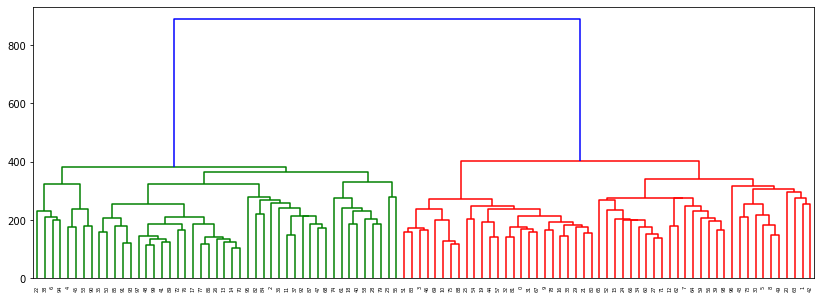

In [49]:
plot_dendogram(img_features_set, 'ward')

In [50]:
df_feature_set = pd.DataFrame(img_features_set)

In [51]:
df_feature_set.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51160,51161,51162,51163,51164,51165,51166,51167,51168,51169,51170,51171,51172,51173,51174,51175,51176,51177,51178,51179,51180,51181,51182,51183,51184,51185,51186,51187,51188,51189,51190,51191,51192,51193,51194,51195,51196,51197,51198,51199
70,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.225271,0.000000,0.000000,0.000000,0.0,0.222226,0.376862,0.000000,0.000000,0.367567,0.000000,0.000000,0.0,0.000000,0.323278,0.737406,0.131177,0.000000,0.0,0.000000,0.915974,0.000000,0.379444,0.0,1.149959,0.000000,0.000000,0.0,0.0,0.412645,0.0,0.00000,0.000000,...,0.148301,0.454005,0.000000,0.000000,1.332398,2.460375,0.000000,0.000000,1.998797,0.420175,0.969968,0.959769,0.044250,0.060513,0.000000,0.000000,0.000000,0.836351,0.000000,0.000000,0.000000,1.105841,0.676618,0.076120,0.000000,0.886070,0.000000,0.483319,1.391692,0.000000,0.000000,0.000000,1.262421,0.000000,0.000000,0.701335,1.653837,0.222679,0.000000,0.000000
8,0.140456,0.000000,0.000000,0.000000,0.626387,0.000000,1.51549,0.000000,0.000000,0.000000,0.000000,0.0,0.546796,0.000000,0.928932,0.000000,0.000000,0.867008,0.000000,0.0,0.000000,0.057639,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.099485,0.0,0.000000,0.000000,0.710929,0.0,0.0,0.000000,0.0,1.69152,0.254885,...,0.000000,0.489187,0.493741,0.000000,0.000000,2.224527,0.209367,0.284624,0.542109,0.000000,1.075760,0.483322,0.000000,0.000000,0.000000,0.947290,0.440848,0.023291,0.155812,0.000000,0.000000,0.623099,0.000000,1.355516,0.729891,1.246077,0.720197,0.000000,0.000000,2.654029,0.000000,0.224442,0.000000,0.441988,0.000000,0.000000,0.000000,0.649652,0.918303,0.671140
74,0.000000,0.000000,0.000000,0.000000,0.000000,1.513588,0.00000,0.000000,0.943864,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.642321,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.618478,0.0,1.135541,0.405821,0.000000,0.000000,0.0,0.000000,0.665797,0.000000,0.0,0.0,0.299382,0.0,0.00000,0.000000,...,3.292939,0.000000,0.061374,0.134734,1.111890,0.000000,0.000000,0.814747,0.000000,1.230983,0.000000,0.537227,0.277494,0.618411,0.941505,0.253467,0.000000,0.000000,0.000000,3.758152,0.000000,0.039760,4.149159,0.566917,0.000000,0.000000,1.270630,0.000000,0.000000,0.000000,0.384028,0.000000,3.468291,0.833147,0.120591,1.095182,0.000000,0.000000,1.501164,0.995596
27,0.000000,0.381697,0.146933,0.000000,0.000000,0.145311,0.00000,0.000000,0.010580,0.000000,0.548814,0.0,0.000000,0.000000,0.000000,0.251183,0.000000,0.055659,0.000000,0.0,0.023625,0.000000,0.026709,0.000000,0.000000,0.0,0.000000,0.000000,0.179541,0.000000,0.0,0.000000,0.223147,0.044473,0.0,0.0,0.649419,0.0,0.00000,0.000000,...,0.000000,1.427956,0.499900,0.055564,0.000000,0.638232,0.478668,0.000000,0.000000,0.000000,1.551102,0.298356,0.205486,0.000000,0.867397,0.000000,0.075664,0.000000,0.000000,0.048066,0.383822,0.152987,0.248073,0.165568,0.000000,0.747248,0.000000,0.000000,0.003380,0.971678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.580380,0.019916,0.200726
12,0.000000,0.000000,0.000000,0.143428,0.440616,0.893238,0.00000,0.000000,0.000000,0.576469,0.312323,0.0,0.000000,0.474461,0.000000,0.055566,0.327459,0.003799,0.626972,0.0,0.000000,1.331030,0.150072,0.348522,0.596560,0.0,0.424643,0.843048,0.000000,0.000000,0.0,1.413152,0.000000,0.255369,0.0,0.0,0.056503,0.0,0.00000,0.000000,...,0.269225,1.403347,0.883016,0.000000,0.000000,0.000000,2.201662,0.081098,0.000000,1.211789,0.968987,1.239333,0.378512,0.000000,0.000000,0.000000,0.000000,0.263854,1.353266,0.052198,0.000000,0.000000,0.588477,0.000000,0.328916,1.457618,0.000000,0.000000,2.315670,0.000000,1.308478,0.784351,0.000000,0.000000,0.172526,0.403737,0.000000,0.000000,1.626977,0.964966


# Analisando dados com uso do PCA


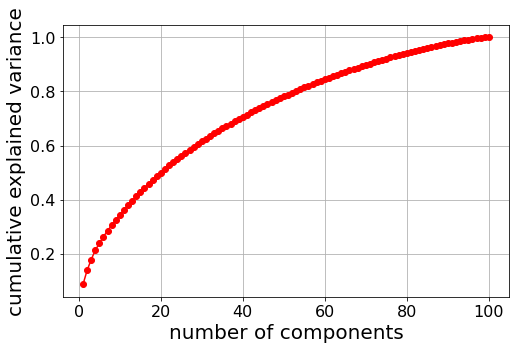

In [52]:
n_components_values =  np.arange(1, min(df_feature_set.shape[0] + 1, len(df_feature_set.columns) + 1))

# Vamos padronizar os dados, de modo a evitar o efeito da escala dos atributos.
scaler = StandardScaler().fit(df_feature_set)
df_features_transformed = scaler.transform(df_feature_set)

# instanciamos o PCA sem especificar o numero de componentes que desejamos
# em seguida ajustamos ao nosso conjunto de dados
pca = PCA().fit(df_features_transformed)

# mostra a variância acumulada para todos os possiveis numeros de componentes
# Notamos que com apenas duas variaveis conseguimos explicar 95% da variancia dos dados

plt.figure(figsize=(8, 5))
plt.plot(n_components_values, np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.xlabel('number of components', fontsize=20)
plt.ylabel('cumulative explained variance', fontsize=20);
plt.xticks(color='k', size=16)
plt.yticks(color='k', size=16)
plt.grid(True)
plt.show(True)

## Utilizando somente as 80 primeiras componentes do PCA no K-means

In [53]:
# Vamos padronizar os dados, de modo a evitar o efeito da escala dos atributos.
scaler = StandardScaler().fit(df_feature_set)
df_features_transformed = scaler.transform(df_feature_set)

# instanciamos o PCA sem especificar o numero de componentes que desejamos
# em seguida ajustamos ao nosso conjunto de dados
pca = PCA(n_components=80).fit(df_features_transformed)

In [54]:
features_set_transformed = pca.transform(df_feature_set)

# Aplicando o novo conjunto transformado no K-means

In [55]:
# Criando um modelo utilizando a técnica de agrupamento K-means

# Definindo o valor de k
k = 2

# Instanciando o modelo
clusters = KMeans(k, random_state = 40)

# Treinando o modelo
clusters.fit(features_set_transformed)

KMeans(n_clusters=2, random_state=40)

In [56]:
# Atualizando a coluna correspondente aos clusters encontrados
images_cluster["clusterid"] = clusters.labels_

In [57]:
# 0 equivale a urso e 1 equivale a touro
images_cluster.sample(10)

,image,clusterid
45,urso (47).jfif,0
29,touro (47).jfif,1
71,touro (28).jfif,1
95,urso (36).jfif,0
0,touro (20).jfif,1
38,urso (39).jfif,0
69,touro (31).jfif,1
44,touro (45).jfif,1
11,urso (1).jfif,0
36,urso (14).jfif,0


In [58]:
quantity_of_objects_0 = images_cluster[images_cluster.clusterid == 0].shape[0]
quantity_of_objects_1 = images_cluster[images_cluster.clusterid == 1].shape[0]

print(f'Quantidade de ursos encontrados: {quantity_of_objects_0}')
print(f'Quantidade de touros encontrados: {quantity_of_objects_1}')

Quantidade de ursos encontrados: 49
Quantidade de touros encontrados: 51


In [59]:
# Criando dois diretórios: urso_2 - para colocarmos as imagens de urso;
# touro_2 - para colocarmos as imagens de tour
os.mkdir('touro_2')
os.mkdir('urso_2')

# Separando as imagens de acordo com o grupo em que o Kmeans determinou que ela
# faz parte.
for image_ in range(len(images_cluster)):
    if images_cluster['clusterid'][image_] == 0:
        shutil.copy(os.path.join(directory_path, images_cluster['image'][image_]), 'urso_2')
    else:
        shutil.copy(os.path.join(directory_path, images_cluster['image'][image_]), 'touro_2')

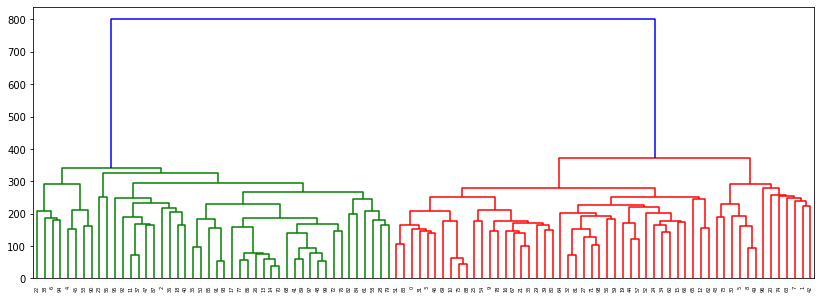

In [60]:
plot_dendogram(features_set_transformed, 'ward')

# Métodos extras

In [27]:
# Cria o plot do cotovelo. 
# Aqui a implementação considera somente o KMeans, mas o método indepente de modelo.
# Para tornar essa função genérica é necessário criar uma função para calcular o WCSS.
def plot_elbow_curve(X, k_list):
    wcss = []
    
    for k in k_list: 
        kmeans = KMeans(n_clusters=k)
        labels_pred = kmeans.fit_predict(X)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(8,6))
    plt.plot(k_list, wcss, '-bo')
    plt.xlabel('k')
    plt.ylabel('WCSS')
    plt.title('Elbow Curve')
    plt.show(True)


# Cria o plot de normalized mutual information
def plot_nmi_curve(model, k_list, X, labels, plot_fmt, plot_label, average_method='arithmetic'):
    nmi = []
    for k in k_list:
        model.set_params(n_clusters=k)
        labels_pred = model.fit_predict(X)
        nmi.append(normalized_mutual_info_score(labels_pred, labels, average_method=average_method))

    plt.plot(k_list, nmi, plot_fmt, label=plot_label)
    plt.xlabel('k', fontsize = 15)
    plt.ylabel('Normalized Mutual information', fontsize = 15)
    plt.grid(True)
    plt.legend()

##### Comandos extras para unix

In [28]:
# Zipping directory
#!zip dados_cluster.zip dados_cluster
#!zip -r urso.zip urso
#!zip -r touro.zip touro

In [29]:
# Unzipping directory
#!unzip dados_cluster.zip

In [35]:
# Removendo pastas
#shutil.rmtree('touro_2')

## Material base - utilizado como referência
* [InceptionV3](https://keras.io/api/applications/inceptionv3/)
* [ImageNet](https://www.image-net.org/)
* [Image Clustering Using k-Means](https://towardsdatascience.com/image-clustering-using-k-means-4a78478d2b83)
* [Scikit Learn](https://scikit-learn.org/stable/index.html)
* Todas as imagens foram extraídas do Google Images, utilizando as buscas "touro" e "urso"